In [13]:
import pandas as pd
from datetime import datetime, timedelta

In [14]:
df_load = [] #Temp list for combining DFs
df_wind = []
df_solar = []

YEARS = ['2022', '2023', '2024']

for year in YEARS:
    df_load.append(pd.read_excel("Native_Load_{}.xlsx".format(year), index_col=0))
    df_wind.append(pd.read_excel("Solar_Wind_{}.xlsx".format(year), sheet_name="Wind Data", index_col= "Time (Hour-Ending)"))
    df_solar.append(pd.read_excel("Solar_Wind_{}.xlsx".format(year), sheet_name="Solar Data", index_col= "Time (Hour-Ending)"))
    
#df init
df_load = pd.concat(df_load)
df_wind = pd.concat(df_wind)
df_solar = pd.concat(df_solar)

In [15]:
problematic_rows = df_load[df_load.index.str.contains("DST", na=False)]
print(problematic_rows) #Rows with DST tag (not parsable by pandas datetime)
df_load.index = df_load.index.str.replace(" DST", "", regex=False)

                             COAST         EAST        FWEST        NORTH  \
Hour Ending                                                                 
11/06/2022 02:00 DST   9331.958672  1104.183137  5094.569030   752.622044   
11/05/2023 02:00 DST  10108.434971  1127.380115  5671.605921   904.897362   
11/03/2024 02:00 DST  12392.327195  1366.024767  6506.165503  1280.902827   

                             NCENT        SOUTH        SCENT         WEST  \
Hour Ending                                                                 
11/06/2022 02:00 DST   8844.275206  2888.351883  5113.815243   938.180082   
11/05/2023 02:00 DST   8789.382953  2784.580564  5598.843114   952.353719   
11/03/2024 02:00 DST  11266.437516  3746.732143  7021.316310  1046.335622   

                             ERCOT  
Hour Ending                         
11/06/2022 02:00 DST  34067.955296  
11/05/2023 02:00 DST  35937.478720  
11/03/2024 02:00 DST  44626.241884  


In [16]:
df_load.index = df_load.index.map(str)
for index, row in df_load.iterrows():

    try:
        date, time = index.split(" ", 1) #Check nans or other non-parseables
    except:
        print(f"Index: {index}")
        print(f"Inde Type: {type(index)}")
        df_load = df_load.drop(index)
        continue

    if time == '24:00': #Some stupid ahh reason 24:00 instead of 00:00
        date = pd.to_datetime(date)
        new_date = date + timedelta(days=1)  #Converts DD 24:00 to DD+1 00:00

        df_load.loc[new_date] = df_load.loc[index] #Copy pasta
        df_load = df_load.drop(index) #Deletes old unusable index
    
df_load.index = pd.to_datetime(df_load.index.astype(str), format='mixed', errors='coerce') #allows mix HH:MM and HH:MM:SS


num_na = pd.isna(df_load.index).sum()
print(f"Rows Missing Values: {num_na}")
print(df_load.dtypes)


Index: nan
Inde Type: <class 'str'>
Rows Missing Values: 0
COAST    float64
EAST     float64
FWEST    float64
NORTH    float64
NCENT    float64
SOUTH    float64
SCENT    float64
WEST     float64
ERCOT    float64
dtype: object


In [17]:
df_solar.index = pd.to_datetime(df_solar.index)
num_na = pd.isna(df_solar.index).sum()
print(f"Rows Missing Values: {num_na}")
print(df_solar.dtypes)

Rows Missing Values: 0
Date                            datetime64[ns]
ERCOT.LOAD                             float64
ERCOT.PVGR.GEN                         float64
Total Solar Installed, MW                int64
Solar Output, % of Load                float64
Solar Output, % of Installed           float64
Solar 1-hr MW change                   float64
Solar 1-hr % change                    float64
Daytime Hour                            object
Ramping Daytime Hour                    object
dtype: object


In [18]:
df_wind.index = pd.to_datetime(df_wind.index)
num_na = pd.isna(df_wind.index).sum()
print(f"Rows Missing Values: {num_na}")
print(df_wind.dtypes)

Rows Missing Values: 0
Date                           datetime64[ns]
ERCOT.LOAD                            float64
ERCOT.WIND.GEN                        float64
Total Wind Installed, MW                int64
Wind Output, % of Load                float64
Wind Output, % of Installed           float64
Wind 1-hr MW change                   float64
Wind 1-hr % change                    float64
dtype: object


In [23]:
# Cell 1: Correlation Between Solar and Load

import matplotlib.pyplot as plt
import seaborn as sns

# If 'ERCOT.LOAD' is in df_solar, you can use that directly.
# Otherwise, if you want correlation with df_load['ERCOT'], you'll need
# the data aligned by time/index. For now, let's assume both are aligned
# and simply do a direct correlation:

corr_load_solar = df_load['ERCOT'].corr(df_solar['ERCOT.PVGR.GEN'])
print("Correlation between ERCOT Load and ERCOT Solar Generation:", corr_load_solar)


Correlation between ERCOT Load and ERCOT Solar Generation: 0.458200215627276


ERCOT Load Summary Statistics:
count    26303.000000
mean     50788.237112
std      11027.131382
min      31796.353940
25%      42822.676514
50%      47824.663549
75%      56690.374319
max      85464.116394
Name: ERCOT, dtype: float64


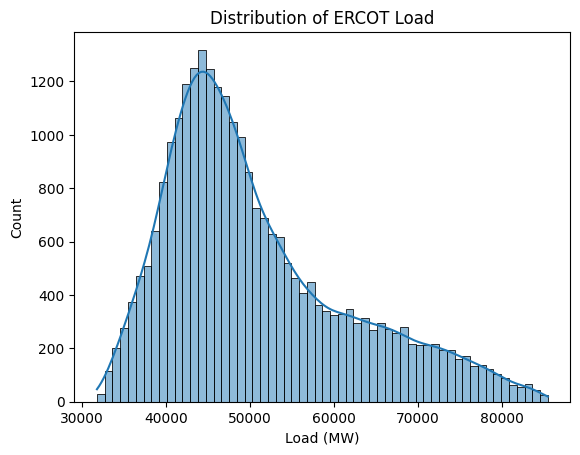

In [24]:
# Cell 2: Univariate Analysis - ERCOT Load

# Basic summary statistics
print("ERCOT Load Summary Statistics:")
print(df_load['ERCOT'].describe())

# Distribution plot
sns.histplot(df_load['ERCOT'], kde=True)
plt.title("Distribution of ERCOT Load")
plt.xlabel("Load (MW)")
plt.show()


ERCOT Solar Generation Summary Statistics:
count    26304.000000
mean      3926.581037
std       5242.853384
min          0.000010
25%          0.309680
50%        247.933716
75%       7593.807340
max      21588.538561
Name: ERCOT.PVGR.GEN, dtype: float64


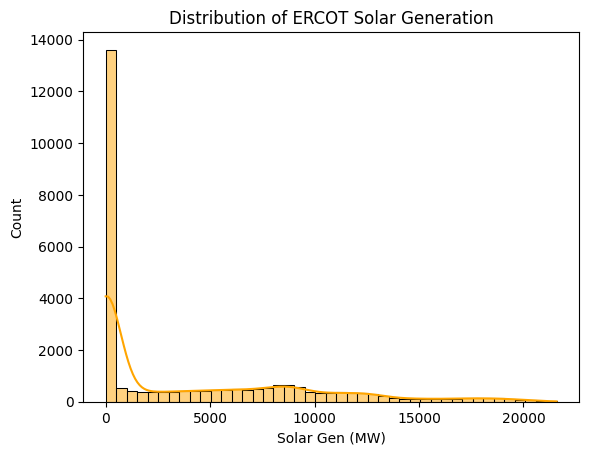

In [25]:
# Cell 3: Univariate Analysis - ERCOT Solar Generation

# Basic summary statistics
print("ERCOT Solar Generation Summary Statistics:")
print(df_solar['ERCOT.PVGR.GEN'].describe())

# Distribution plot
sns.histplot(df_solar['ERCOT.PVGR.GEN'], kde=True, color='orange')
plt.title("Distribution of ERCOT Solar Generation")
plt.xlabel("Solar Gen (MW)")
plt.show()


Correlation Matrix (Solar-Related Columns, Excluding 'ERCOT.LOAD'):
                                      Date  ERCOT.PVGR.GEN  \
Date                          1.000000e+00        0.221626   
ERCOT.PVGR.GEN                2.216258e-01        1.000000   
Total Solar Installed, MW     9.884379e-01        0.222136   
Solar Output, % of Load       1.942951e-01        0.966525   
Solar Output, % of Installed -2.830755e-02        0.916894   
Solar 1-hr MW change         -4.749567e-08        0.176289   
Solar 1-hr % change          -1.152612e-03       -0.013304   
Daytime Hour                 -6.597261e-03        0.674450   
Ramping Daytime Hour         -5.806916e-03        0.618925   

                              Total Solar Installed, MW  \
Date                                       9.884379e-01   
ERCOT.PVGR.GEN                             2.221357e-01   
Total Solar Installed, MW                  1.000000e+00   
Solar Output, % of Load                    1.968910e-01   
Solar Output, % 

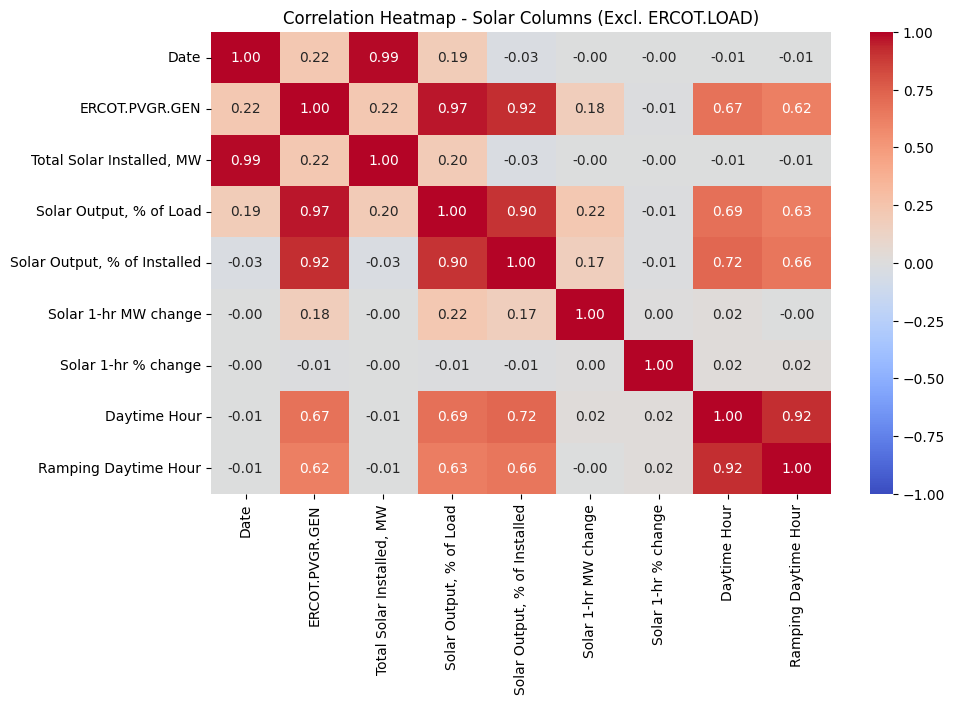

In [26]:
# Cell 4: Correlation Among Solar Columns (Excluding 'ERCOT.LOAD')

# Gather solar-related columns except 'ERCOT.LOAD'
solar_cols = [col for col in df_solar.columns if col != 'ERCOT.LOAD']
df_solar_subset = df_solar[solar_cols]

# Correlation matrix
corr_solar = df_solar_subset.corr()
print("Correlation Matrix (Solar-Related Columns, Excluding 'ERCOT.LOAD'):")
print(corr_solar)

# Visualize as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_solar, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap - Solar Columns (Excl. ERCOT.LOAD)")
plt.show()
